In [1]:
import cooler
import pandas as pd
import pybedtools as bt
import seaborn as sns

import numpy as np
import itertools

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import conorm
import time
from multiprocessing import Pool

from matplotlib import gridspec



In [2]:
H3K27ac = pd.read_table('../January-23/data/H3K27ac_Loops.bedpe',names=['Chr1', 'Start1', 'End1', 'Chr2', 'Start2', 'End2', 'Name', 'PET', 'PADJ'])
#H3K27ac = H3K27ac[H3K27ac['PADJ'] > 5].reset_index(drop=True)

H3K4me3 = pd.read_table('../January-23/data/H3K4me3_Loops.bedpe',names=['Chr1', 'Start1', 'End1', 'Chr2', 'Start2', 'End2', 'Name', 'PET', 'PADJ'])
#H3K4me3 = H3K4me3[H3K4me3['PADJ'] > 5].reset_index(drop=True)


all_bedpe = pd.concat((H3K27ac, H3K4me3))

all_bedpe['Start1'] -= 499
all_bedpe['End1'] += 499
all_bedpe['Start2'] -= 499
all_bedpe['End2'] += 499

all_bedpe['Name'] = all_bedpe['Chr1'] + ':' + all_bedpe['Start1'].astype(str) +'-'+ all_bedpe['End1'].astype(str) +','+ all_bedpe['Chr2'] + ':' + all_bedpe['Start2'].astype(str) +'-'+ all_bedpe['End2'].astype(str)

all_bedpe

Chr1    Start1      End1  Chr2    Start2      End2  \
0       chr1    712000    713000  chr1   1167000   1168000   
1       chr1    712000    713000  chr1    742000    743000   
2       chr1    712000    713000  chr1    757000    758000   
3       chr1    712000    713000  chr1    792000    793000   
4       chr1    712000    713000  chr1    837000    838000   
...      ...       ...       ...   ...       ...       ...   
278486  chrY  58987000  58988000  chrY  59017000  59018000   
278487  chrY  58997000  58998000  chrY  59002000  59003000   
278488  chrY  58997000  58998000  chrY  59032000  59033000   
278489  chrY  59002000  59003000  chrY  59017000  59018000   
278490  chrY  59017000  59018000  chrY  59022000  59023000   

                                                 Name     PET      PADJ  
0             chr1:712000-713000,chr1:1167000-1168000   11779   2.04154  
1               chr1:712000-713000,chr1:742000-743000    3319  10.69450  
2               chr1:712000-713000,chr1:757000-758000    3318  42.01160  
3               chr1:712000-713000,chr1:792000-793000    6322  24.29350  
4               chr1:712000-713000,chr1:837000-838000   11778   2.85275  
...                                               ...     ...       ...  
278486  chrY:58987000-58988000,chrY:59017000-59018000  277990  23.51260  
278487  chrY:58997000-58998000,chrY:59002000-59003000  277989  24.67720  
278488  chrY:58997000-58998000,chrY:59032000-59033000  277993   3.88449  
278489  chrY:59002000-59003000,chrY:59017000-59018000  277991  13.06090  
278490  chrY:59017000-59018000,chrY:59022000-59023000  277988  27.53240  

[574817 rows x 9 columns]

In [5]:
C = cooler.Cooler(f"../January-23/data/cool/H3K27ac_Vh.cool")
bins = C.bins()[:].copy()
bins = bins.reset_index()
bins = bt.BedTool.from_dataframe(bins[["chrom","start","end", "index"]]) # bin locations' indexes


In [26]:
maps

0          1          2                          3      4  \
0       chr14   27282000   27283000    chr14:27282000-27283000  chr14   
1       chr20   22672000   22673000    chr20:22672000-22673000  chr20   
2        chr1   33537000   33538000     chr1:33537000-33538000   chr1   
3       chr16   79077000   79078000    chr16:79077000-79078000  chr16   
4        chr5  139927000  139928000   chr5:139927000-139928000   chr5   
...       ...        ...        ...                        ...    ...   
210056  chr16   46882000   46883000    chr16:46882000-46883000  chr16   
210057  chr13   47352000   47353000    chr13:47352000-47353000  chr13   
210058  chr12   44352000   44353000    chr12:44352000-44353000  chr12   
210059  chr17   42312000   42313000    chr17:42312000-42313000  chr17   
210060  chr10  124742000  124743000  chr10:124742000-124743000  chr10   

                5          6       7  
0        27280000   27285000  445449  
1        22670000   22675000  548257  
2        33535000   33540000    6707  
3        79075000   79080000  497785  
4       139925000  139930000  204312  
...           ...        ...     ...  
210056   46880000   46885000  491346  
210057   47350000   47355000  426429  
210058   44350000   44355000  399058  
210059   42310000   42315000  508503  
210060  124740000  124745000  361027  

[210061 rows x 8 columns]

In [6]:

anchor1 = set(a.split(",")[0] for a in all_bedpe["Name"])
anchor2 = set(a.split(",")[1] for a in all_bedpe["Name"])
tmp = pd.DataFrame({"Name": list(anchor1.union(anchor2))})
ancs = tmp["Name"].str.split(":|-", expand=True)
ancs["Name"] = tmp["Name"]
ancs = bt.BedTool.from_dataframe(ancs) # anhcor locations

maps = bt.BedTool.intersect(ancs, bins, wa=True, wb=True).to_dataframe(names=range(8)) # which loops correspond to which indexed bin.
cached = dict(zip(maps[3], maps[7]))

In [28]:
mat = C.matrix(balance=True)

ancs = pd.DataFrame({'Chr': ['chr19', 'chr8'], 'Start': [51358171, 128747680], 'End': [51358171, 128747680], 'Name': ['KLK3', 'MYC']})
ancs = bt.BedTool.from_dataframe(ancs) # anhcor locations
ancs
maps = bt.BedTool.intersect(ancs, bins, wa=True, wb=True).to_dataframe(names=range(8)) # which loops correspond to which indexed bin.
cached = dict(zip(maps[3], maps[7]))

cached

{'KLK3': 542168, 'MYC': 304312}

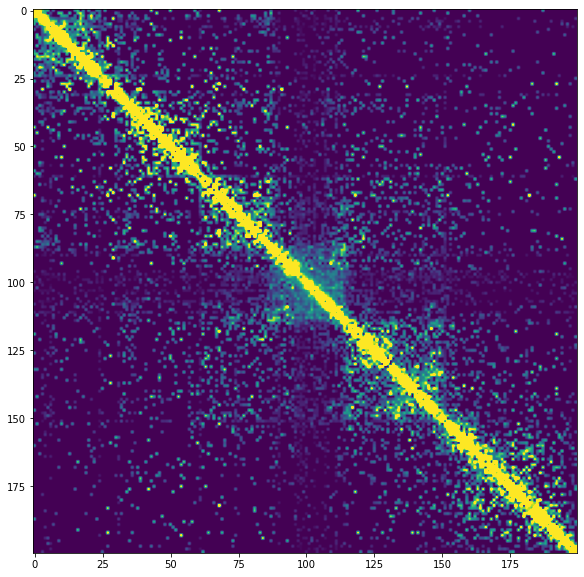

In [30]:

w = 100

tmp = mat[cached['KLK3']-w:cached['KLK3']+w, cached['KLK3']-w:cached['KLK3']+w]

plt.figure(figsize=[10,10])
plt.imshow(tmp+1, vmin=1,vmax=1.02)

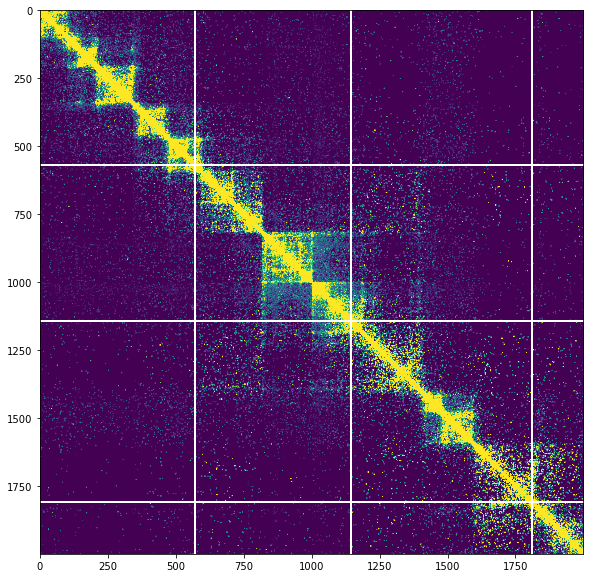

In [39]:

w = 1000

tmp = mat[cached['MYC']-w:cached['MYC']+w, cached['MYC']-w:cached['MYC']+w]

plt.figure(figsize=[10,10])
plt.imshow(tmp+1, vmax=1.002,vmin=1 )

In [10]:
# >>> H3K27ac >>>
print('H3K27ac Starting')

H3K27ac_matrix = {}
H3K27ac_C = {}


def takeSignal(ab):
    a, b = ab
    return H3K27ac_matrix[t][cached[a], cached[b]][0][0]


for t in ["Vh","30m","4h", "16h","72h"]:
    print(t)
    # >>> 1 >>>
    H3K27ac_C[t] = cooler.Cooler(f"data/cool/H3K27ac_{t}.cool")
    H3K27ac_matrix[t] = H3K27ac_C[t].matrix(balance=False)
    # <<< 1 <<<
    
    if t == 'Vh':
        # >>> 2 >>>
        bins = H3K27ac_C[t].bins()[:].copy()
        bins = bins.reset_index()
        bins = bt.BedTool.from_dataframe(bins[["chrom","start","end", "index"]])

        tmp = pd.DataFrame({"Name": list(set(a.split(",")[0] for a in all_bedpe["Name"]).union( set(a.split(",")[1] for a in all_bedpe["Name"])))})
        ancs = tmp["Name"].str.split(":|-", expand=True)
        ancs["Name"] = tmp["Name"]
        ancs = bt.BedTool.from_dataframe(ancs)

        maps = bt.BedTool.intersect(ancs, bins, wa=True, wb=True).to_dataframe(names=range(8))
        cached = dict(zip(maps[3], maps[7]))
        # <<< 2 <<<

    # >>> 3 >>>
    l = [(name.split(',')[0], name.split(',')[1]) for name in all_bedpe['Name'].tolist()]
    with Pool(20) as p:
        S = p.map(takeSignal, l)

    
    all_bedpe[t+'_H3K27ac'] = S
    # <<< 3 <<<
    print()
    
# <<< H3K27ac <<<



H3K27ac Starting
Vh


KeyboardInterrupt: 

In [4]:

A = np.nan_to_num(all_bedpe[["Vh_H3K27ac", "30m_H3K27ac","4h_H3K27ac","16h_H3K27ac", "72h_H3K27ac"]].values)

R = 1 /(conorm.tmm_norm_factors(A) * A.sum(0) / 1000000)

N = A * R

for i, t in enumerate(["Vh","30m","4h", "16h","72h"]):
    all_bedpe[t+"_H3K27ac.tmm"] = N[:,i]
    all_bedpe[["Chr1","Start1", "End1", "Chr2","Start2","End2", "Name", t+"_H3K27ac.tmm"]].to_csv(f"data/ALL_H3K27ac_{t}.tmm.bedpe",sep="\t", index=False , header=False)
    all_bedpe.loc[all_bedpe['PADJ'] > 5, ["Chr1","Start1", "End1", "Chr2","Start2","End2", "Name", t+"_H3K27ac.tmm"]].to_csv(f"data/ALL_H3K27ac_{t}.e5.tmm.bedpe",sep="\t", index=False , header=False)
  

In [ ]:
# >>> H3K4me3 >>>
print('H3K4me3 Starting')

H3K4me3_matrix = {}
H3K4me3_C = {}


def takeSignal(ab):
    a, b = ab
    return H3K4me3_matrix[t][cached[a], cached[b]][0][0]


for t in ["Vh","30m","4h", "16h","72h"]:
    print(t)
    # >>> 1 >>>
    H3K4me3_C[t] = cooler.Cooler(f"data/cool/H3K4me3_{t}.cool")
    H3K4me3_matrix[t] = H3K4me3_C[t].matrix(balance=False)
    # <<< 1 <<<
    
    if t == 'Vh':
        # >>> 2 >>>
        bins = H3K4me3_C[t].bins()[:].copy()
        bins = bins.reset_index()
        bins = bt.BedTool.from_dataframe(bins[["chrom","start","end", "index"]])

        tmp = pd.DataFrame({"Name": list(set(a.split(",")[0] for a in all_bedpe["Name"]).union( set(a.split(",")[1] for a in all_bedpe["Name"])))})
        ancs = tmp["Name"].str.split(":|-", expand=True)
        ancs["Name"] = tmp["Name"]
        ancs = bt.BedTool.from_dataframe(ancs)

        maps = bt.BedTool.intersect(ancs, bins, wa=True, wb=True).to_dataframe(names=range(8))
        cached = dict(zip(maps[3], maps[7]))
        # <<< 2 <<<

    # >>> 3 >>>
    l = [(name.split(',')[0], name.split(',')[1]) for name in all_bedpe['Name'].tolist()]
    with Pool(20) as p:
        S = p.map(takeSignal, l)

    
    all_bedpe[t+'_H3K4me3'] = S
    # <<< 3 <<<
    print()
    
# <<< H3K4me3 <<<



H3K4me3 Starting
Vh

30m

4h

16h

72h



In [6]:

A = np.nan_to_num(all_bedpe[["Vh_H3K4me3", "30m_H3K4me3","4h_H3K4me3","16h_H3K4me3", "72h_H3K4me3"]].values)

R = 1 /(conorm.tmm_norm_factors(A) * A.sum(0) / 1000000)

N = A * R

for i, t in enumerate(["Vh","30m","4h", "16h","72h"]):
    all_bedpe[t+".tmm_H3K4me3"] = N[:,i]
    all_bedpe[["Chr1","Start1", "End1", "Chr2","Start2","End2", "Name", t+".tmm_H3K4me3"]].to_csv(f"data/ALL_H3K4me3_{t}.tmm.bedpe",sep="\t", index=False , header=False)
    all_bedpe.loc[all_bedpe['PADJ'] > 5, ["Chr1","Start1", "End1", "Chr2","Start2","End2", "Name", t+".tmm_H3K4me3"]].to_csv(f"data/ALL_H3K4me3_{t}.e5.tmm.bedpe",sep="\t", index=False , header=False)
  

# Individual

In [10]:

H3K27ac_C = {}
H3K4me3_C = {}
H3K27ac_matrix = {}
H3K4me3_matrix = {}
for i, t in enumerate(["Vh","30m","4h", "16h","72h"]):
    # >>> 1 >>>
    H3K27ac_C[t] = cooler.Cooler(f"../January-23/data/cool/H3K27ac_{t}.cool")
    H3K4me3_C[t] = cooler.Cooler(f"../January-23/data/cool/H3K4me3_{t}.cool")
    H3K27ac_matrix[t] = H3K27ac_C[t].matrix(balance=False)
    H3K4me3_matrix[t] = H3K4me3_C[t].matrix(balance=False)
    # <<< 1 <<<

    if t == 'Vh':
        # >>> 2 >>>
        bins = H3K27ac_C[t].bins()[:].copy()
        bins = bins.reset_index()
        bins = bt.BedTool.from_dataframe(bins[["chrom","start","end", "index"]])
        
        tmp = pd.DataFrame({"Name": list(set(a.split(",")[0] for a in all_bedpe["Name"]).union( set(a.split(",")[1] for a in all_bedpe["Name"])))})
        ancs = tmp["Name"].str.split(":|-", expand=True)
        ancs["Name"] = tmp["Name"]
        ancs = bt.BedTool.from_dataframe(ancs)

        maps = bt.BedTool.intersect(ancs, bins, wa=True, wb=True).to_dataframe(names=range(8))
        cached = dict(zip(maps[3], maps[7]))
        # <<< 2 <<<

    #break
    #l = [(name.split(',')[0], name.split(',')[1]) for name in all_bedpe['Name'].tolist()]
    #with Pool(20) as p:
    #S = p.map(takeSignal, l)


    

In [14]:
l = [(name.split(',')[0], name.split(',')[1]) for name in all_bedpe['Name'].tolist()]
a, b = l[0]
#H3K27ac_C[t].bins()[:].copy()
a = cached[a]
b = cached[b]
H3K27ac_matrix[t][a-5:a+6, b-5:b+6]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=int32)

In [21]:

def plotRegion(region, gene, promoter, ticks=None, enhancers=None ,vmax=100):

    fig = plt.figure(figsize=[25,10], dpi=300)

    gs = gridspec.GridSpec(nrows=2, ncols=5, wspace=0.2, hspace=0.2, top=0.8)
    for i, t in enumerate(["Vh","30m","4h", "16h","72h"]):
        data = H3K27ac_C[t].matrix(balance=False).fetch(region)
        m = H3K27ac_C[t].matrix(balance=False).fetch(region)
        m = m / m.sum()
        #m = np.e**m
        print(m.max())
        ax = fig.add_subplot(gs[0,i])
        im = ax.matshow(
            m, cmap='Blues', vmax=vmax
        )
        if ticks is not None:
            plt.xticks([(i*10**6 - region[1]) / 5000 for i in  ticks], ticks, fontsize=15)
            plt.yticks([(i*10**6 - region[1]) / 5000 for i in  ticks], ticks, fontsize=15)

        ax.grid(color='#888888', linestyle='--', linewidth=0.5)
        
        p = (promoter - region[1]) / 5000
        
        plt.scatter([p], [p], alpha=0.5, c='#FFFFFF')
        
        if enhancers is not None:
            e = [(e - region[1]) / 5000 for e in enhancers] 
        
            plt.scatter([e], [e], alpha=0.5, c='#e32f27')
        
        if i == 0:
            plt.ylabel('H3K27ac', fontsize=30)
            
        

    
    for i, t in enumerate(["Vh","30m","4h", "16h","72h"]):
        m = H3K4me3_C[t].matrix(balance=False).fetch(region)
        m = m / m.sum()
        #m = np.e**m
        print(m.max())
        ax = fig.add_subplot(gs[1,i])
        im = ax.matshow(
            m, cmap='Greens', vmax=vmax
        )
        
        if ticks is not None:
            plt.xticks([(i*10**6 - region[1]) / 5000 for i in  ticks], ticks, fontsize=15)
            plt.yticks([(i*10**6 - region[1]) / 5000 for i in  ticks], ticks, fontsize=15)

        ax.grid(color='#888888', linestyle='--', linewidth=0.5)
        
        p = (promoter - region[1]) / 5000
        
        plt.scatter([p], [p], alpha=0.5, c='#FFFFFF')
        
        
        if enhancers is not None:
            e = [(e - region[1]) / 5000 for e in enhancers] 
        
            plt.scatter([e], [e], alpha=0.5, c='#e32f27')

        if i == 0:
            plt.ylabel('H3K4me3', fontsize=30)

        plt.xlabel(t, fontsize=30)
        
    
    fig.suptitle(gene, fontsize=100)
    

In [24]:
!bedtools window -a ../data/BED/BEDPRO.bed -b ../data/BED/ARcre.bed -w 1000000 -v  | grep 'High'| head

chr1	1164881	1169881	-	SDF4	ENST00000360001.6	115.9890658	chr1:1164881-1169881	High	107.9031232304351	110.44348416075474	115.72116832862402	115.28915623291844	128.66172593628292
chr1	1165129	1170129	+	B3GALT6	ENST00000379198.2	44.5340443	chr1:1165129-1170129	High	38.71376617667888	48.03208783653346	46.46679469613467	48.142891705104795	41.80683888377605
chr1	1206744	1211744	-	UBE2J2	ENST00000348298.7	39.7422136	chr1:1206744-1211744	High	39.4350072308339	40.9775417897399	41.72937336425378	37.78424263596263	38.37054979104304
chr1	1257571	1262571	-	CPSF3L	ENST00000435064.1	42.7799161	chr1:1257571-1262571	High	42.86087064248819	47.95367101303602	42.32764337614176	43.18508003838339	37.86100305355284
chr1	1257647	1262647	+	GLTPD1	ENST00000343938.4	33.7107297	chr1:1257647-1262647	High	33.39842019300305	35.16128741099003	36.327050606077954	33.63599917562961	29.979954886907755
chr1	1282230	1287230	-	DVL1	ENST00000378888.5	41.4693085	chr1:1282230-1287230	High	34.70147874777735	42.72346553487229	3

0.004173764906303236
0.005382907880133185
0.0038597124948994265
0.007286558329861
0.005327165947715816
0.003289570951240427
0.0038666504171329173
0.004092150301911465
0.0033149057516703214
0.001996714267660811


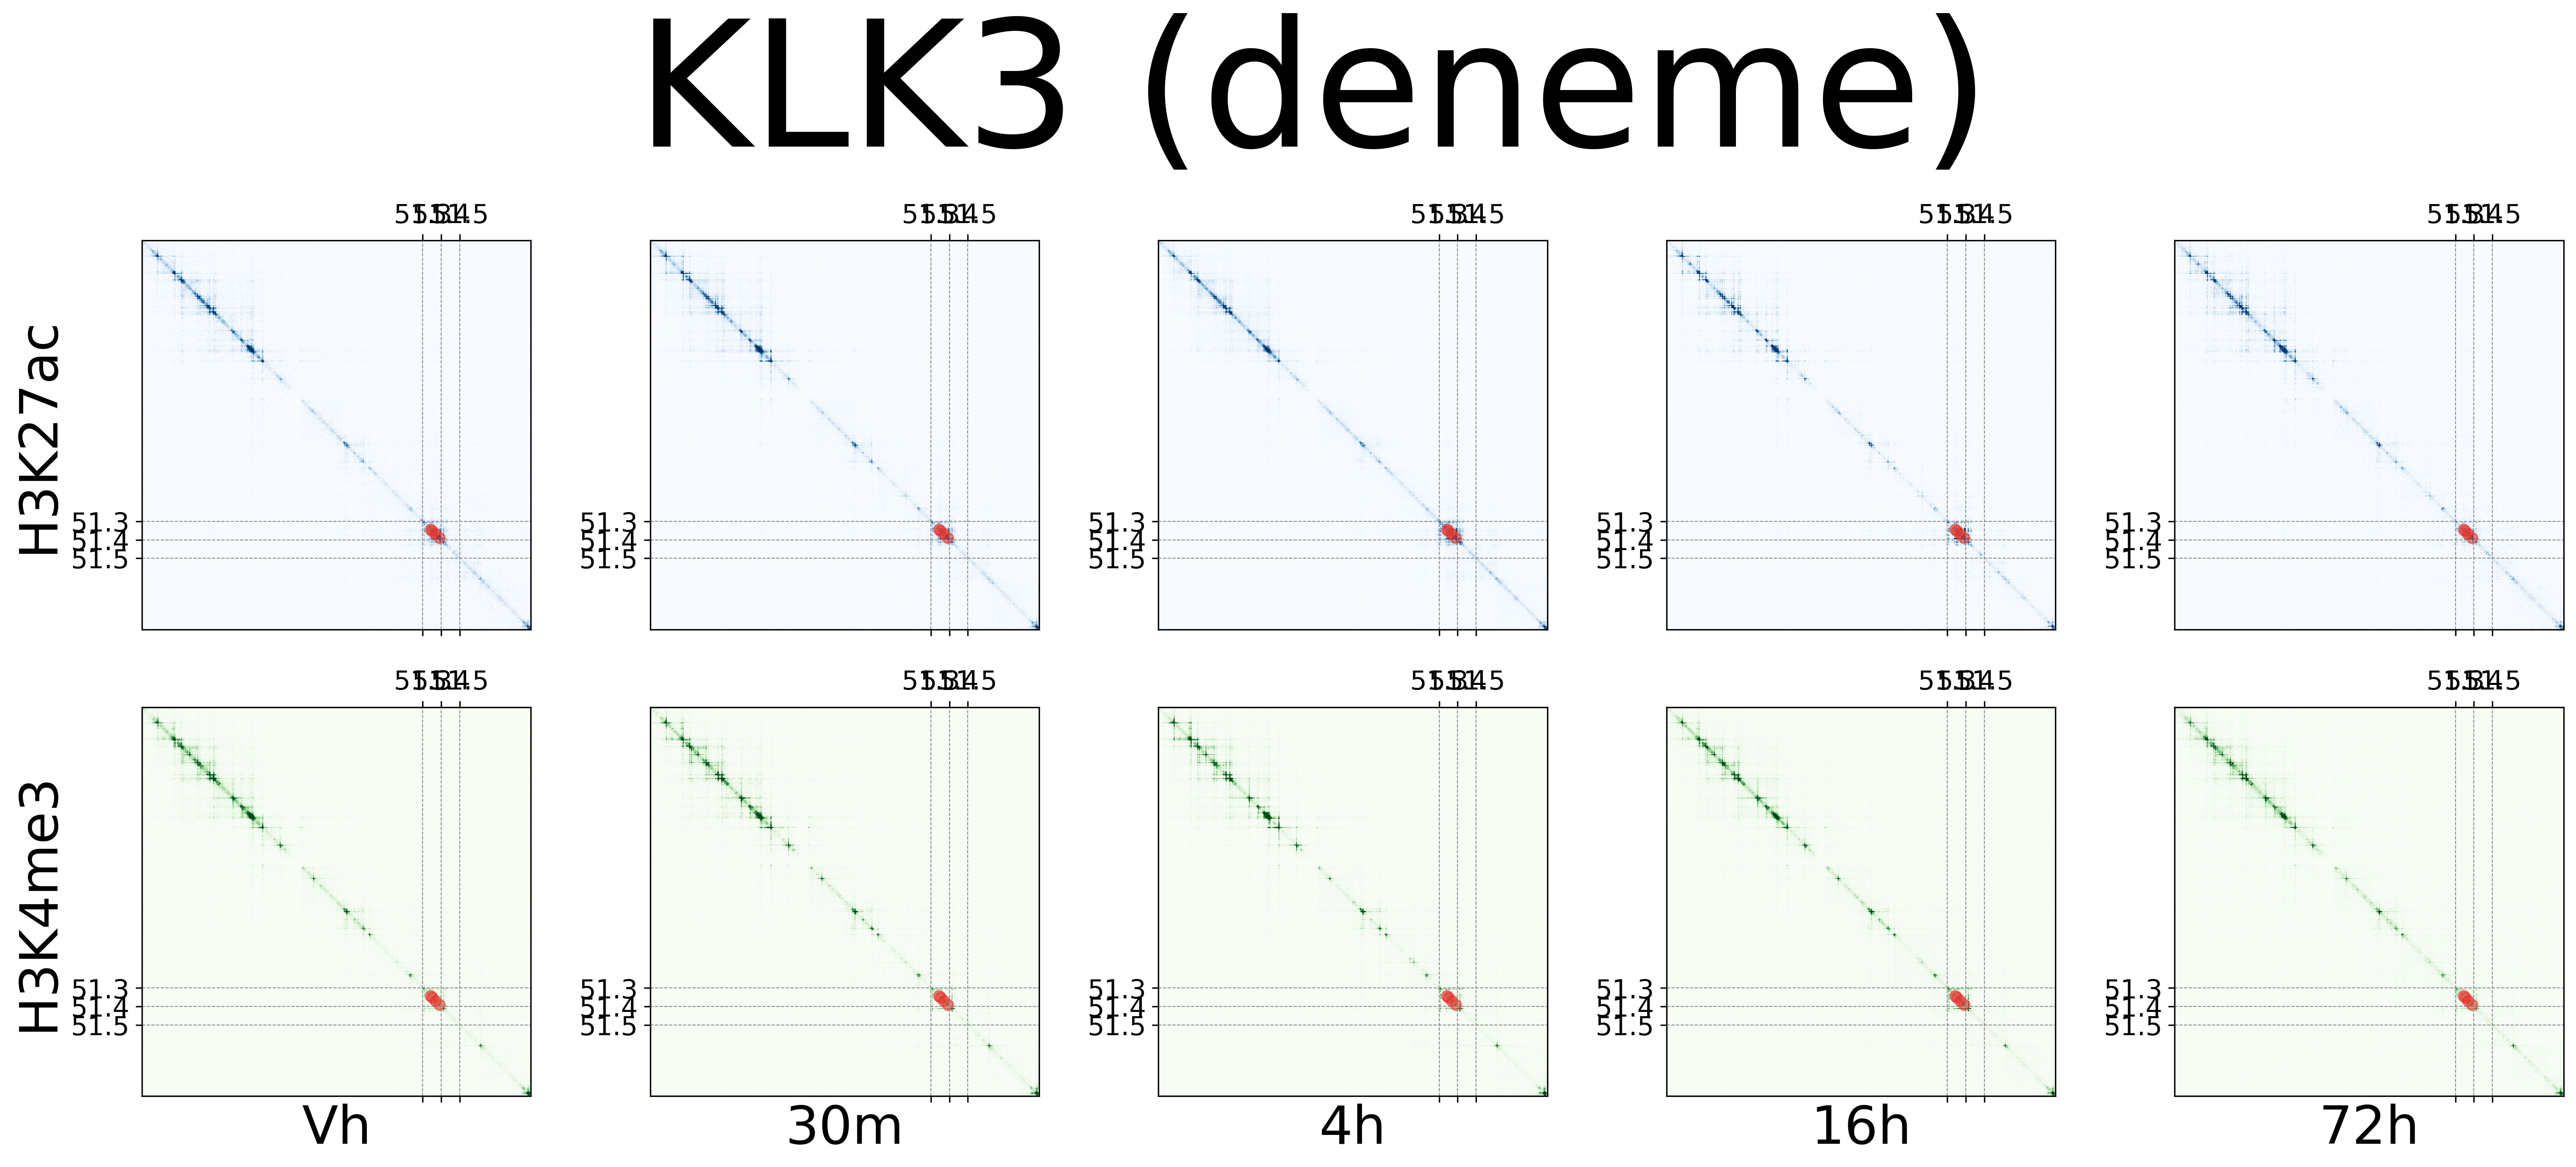

In [23]:
chr19:49782925-51880077
region = ('chr19',49782925,51880077)
enhancers = (51342895, 51352016, 51370076, 51390631)
plotRegion(region, 'KLK3 (deneme)',51355671, [51.3,51.4,51.5], enhancers, 0.0005)

0.011271261698203429
0.011614314265243788
0.012284293653114946
0.021315727422777646
0.015176543464794549
0.007304044478360406
0.012112403100775194
0.013511766227049393
0.013483364050829373
0.006345733041575492


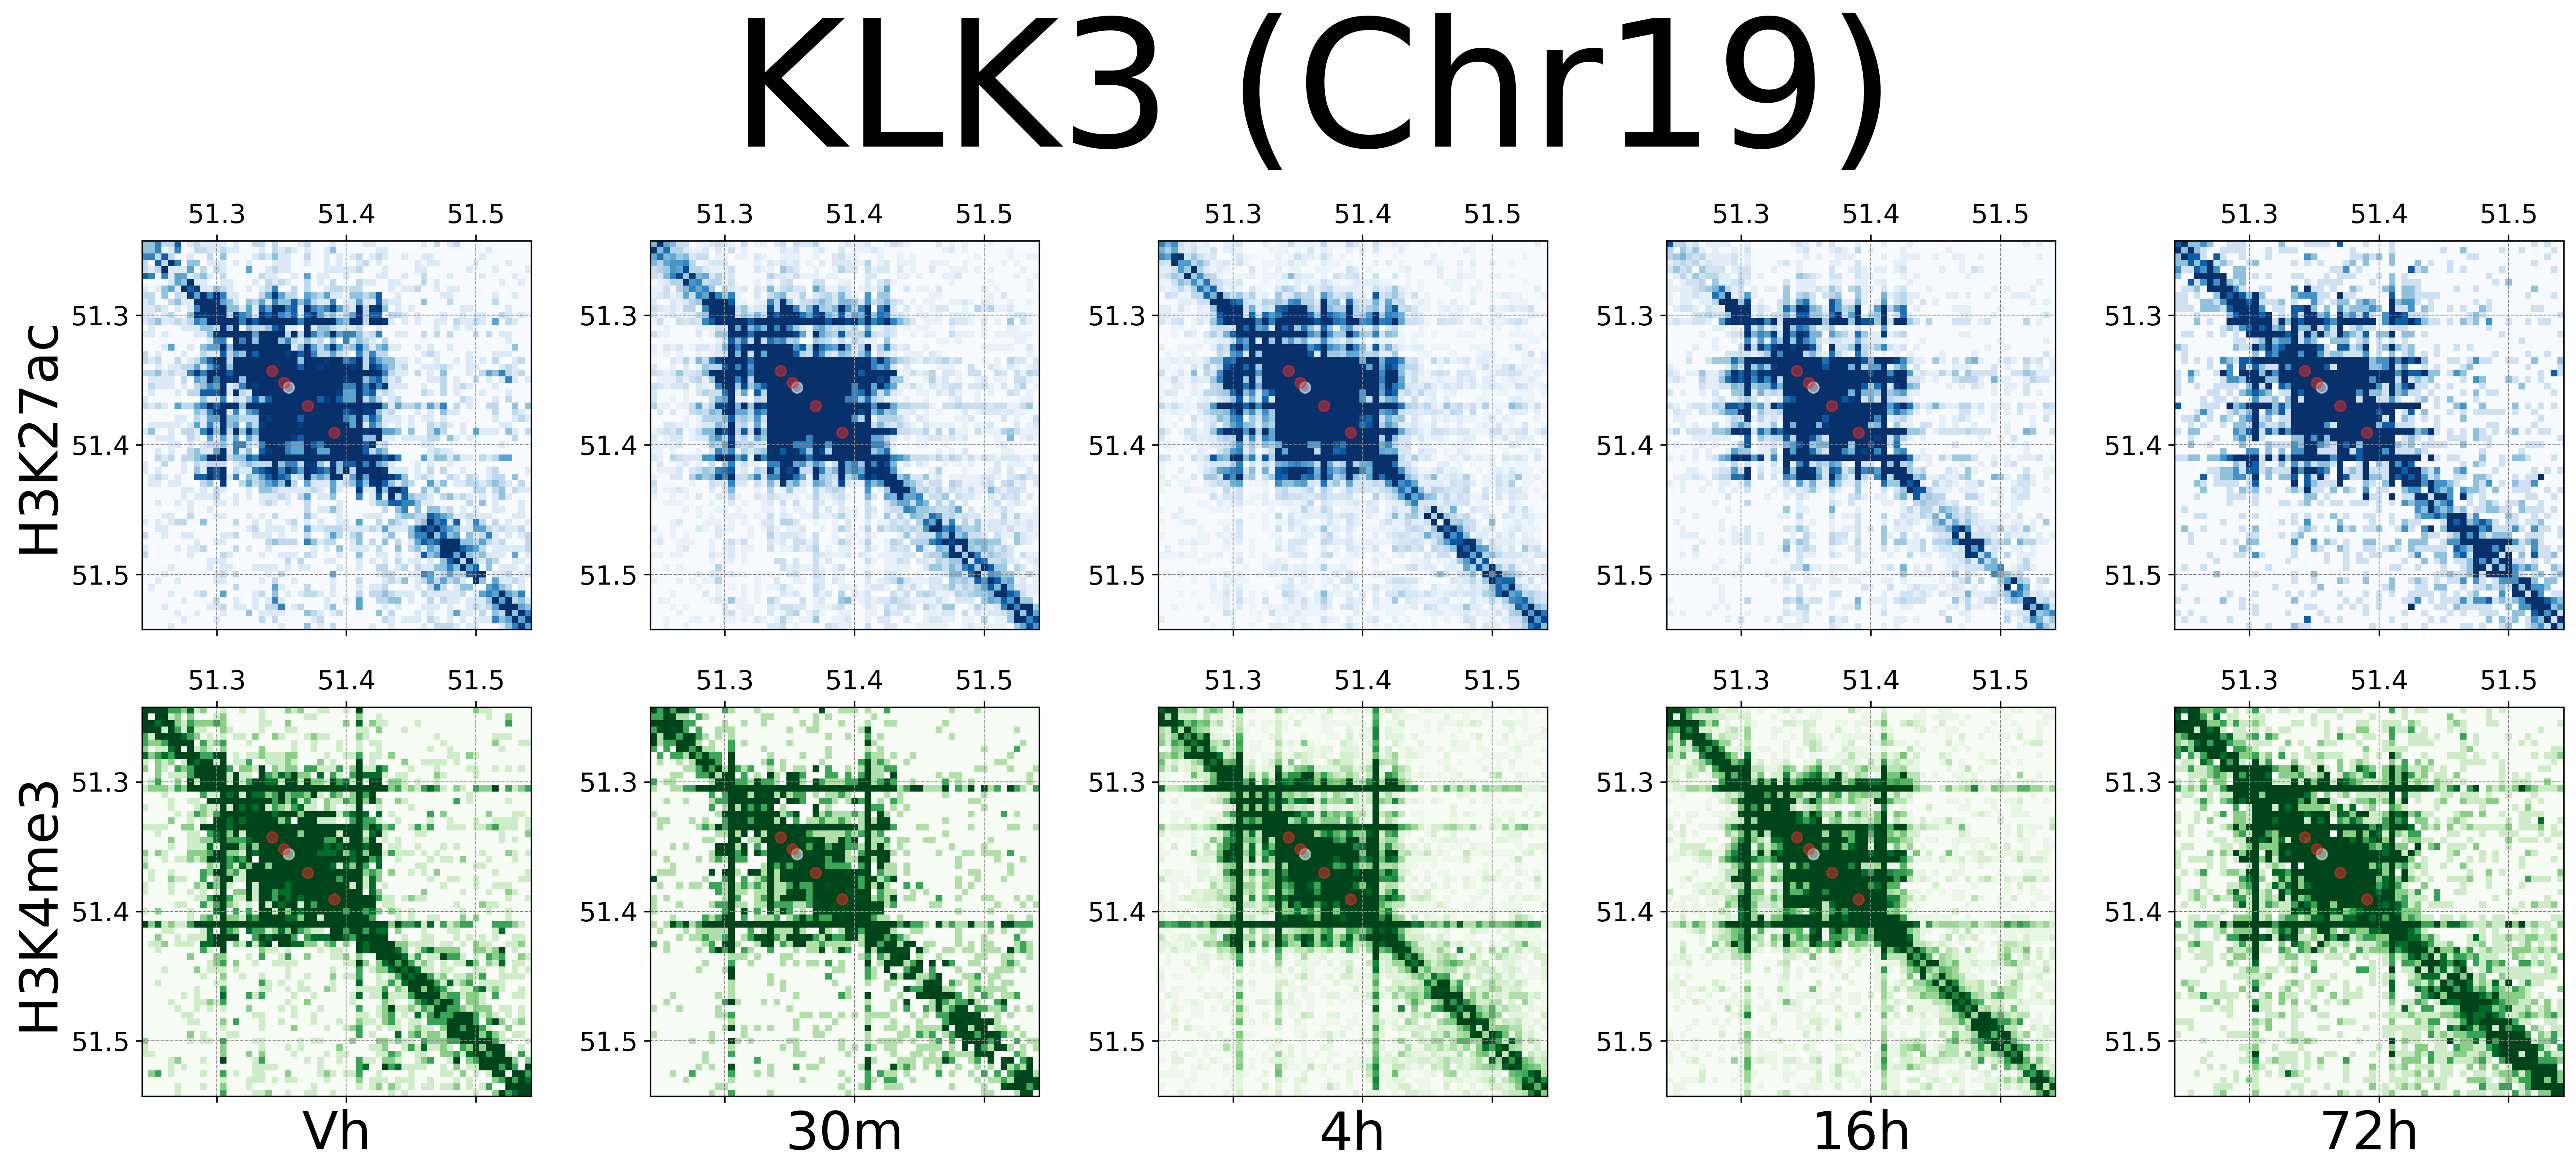

In [14]:


region = ('chr19',51295000-(50*1000),51295000+(250*1000))
enhancers = (51342895, 51352016, 51370076, 51390631)
plotRegion(region, 'KLK3 (Chr19)',51355671, [51.3,51.4,51.5], enhancers, 0.0005)

In [1]:
49541590 - 51638742

-2097152

0.003973908912909991
0.005033150763908908
0.0036986942391394927
0.006824299308564395
0.004903367776502105
0.003082165688915978
0.003621534119209696
0.0038369442921847505
0.003105964512908562
0.0018973509138506617


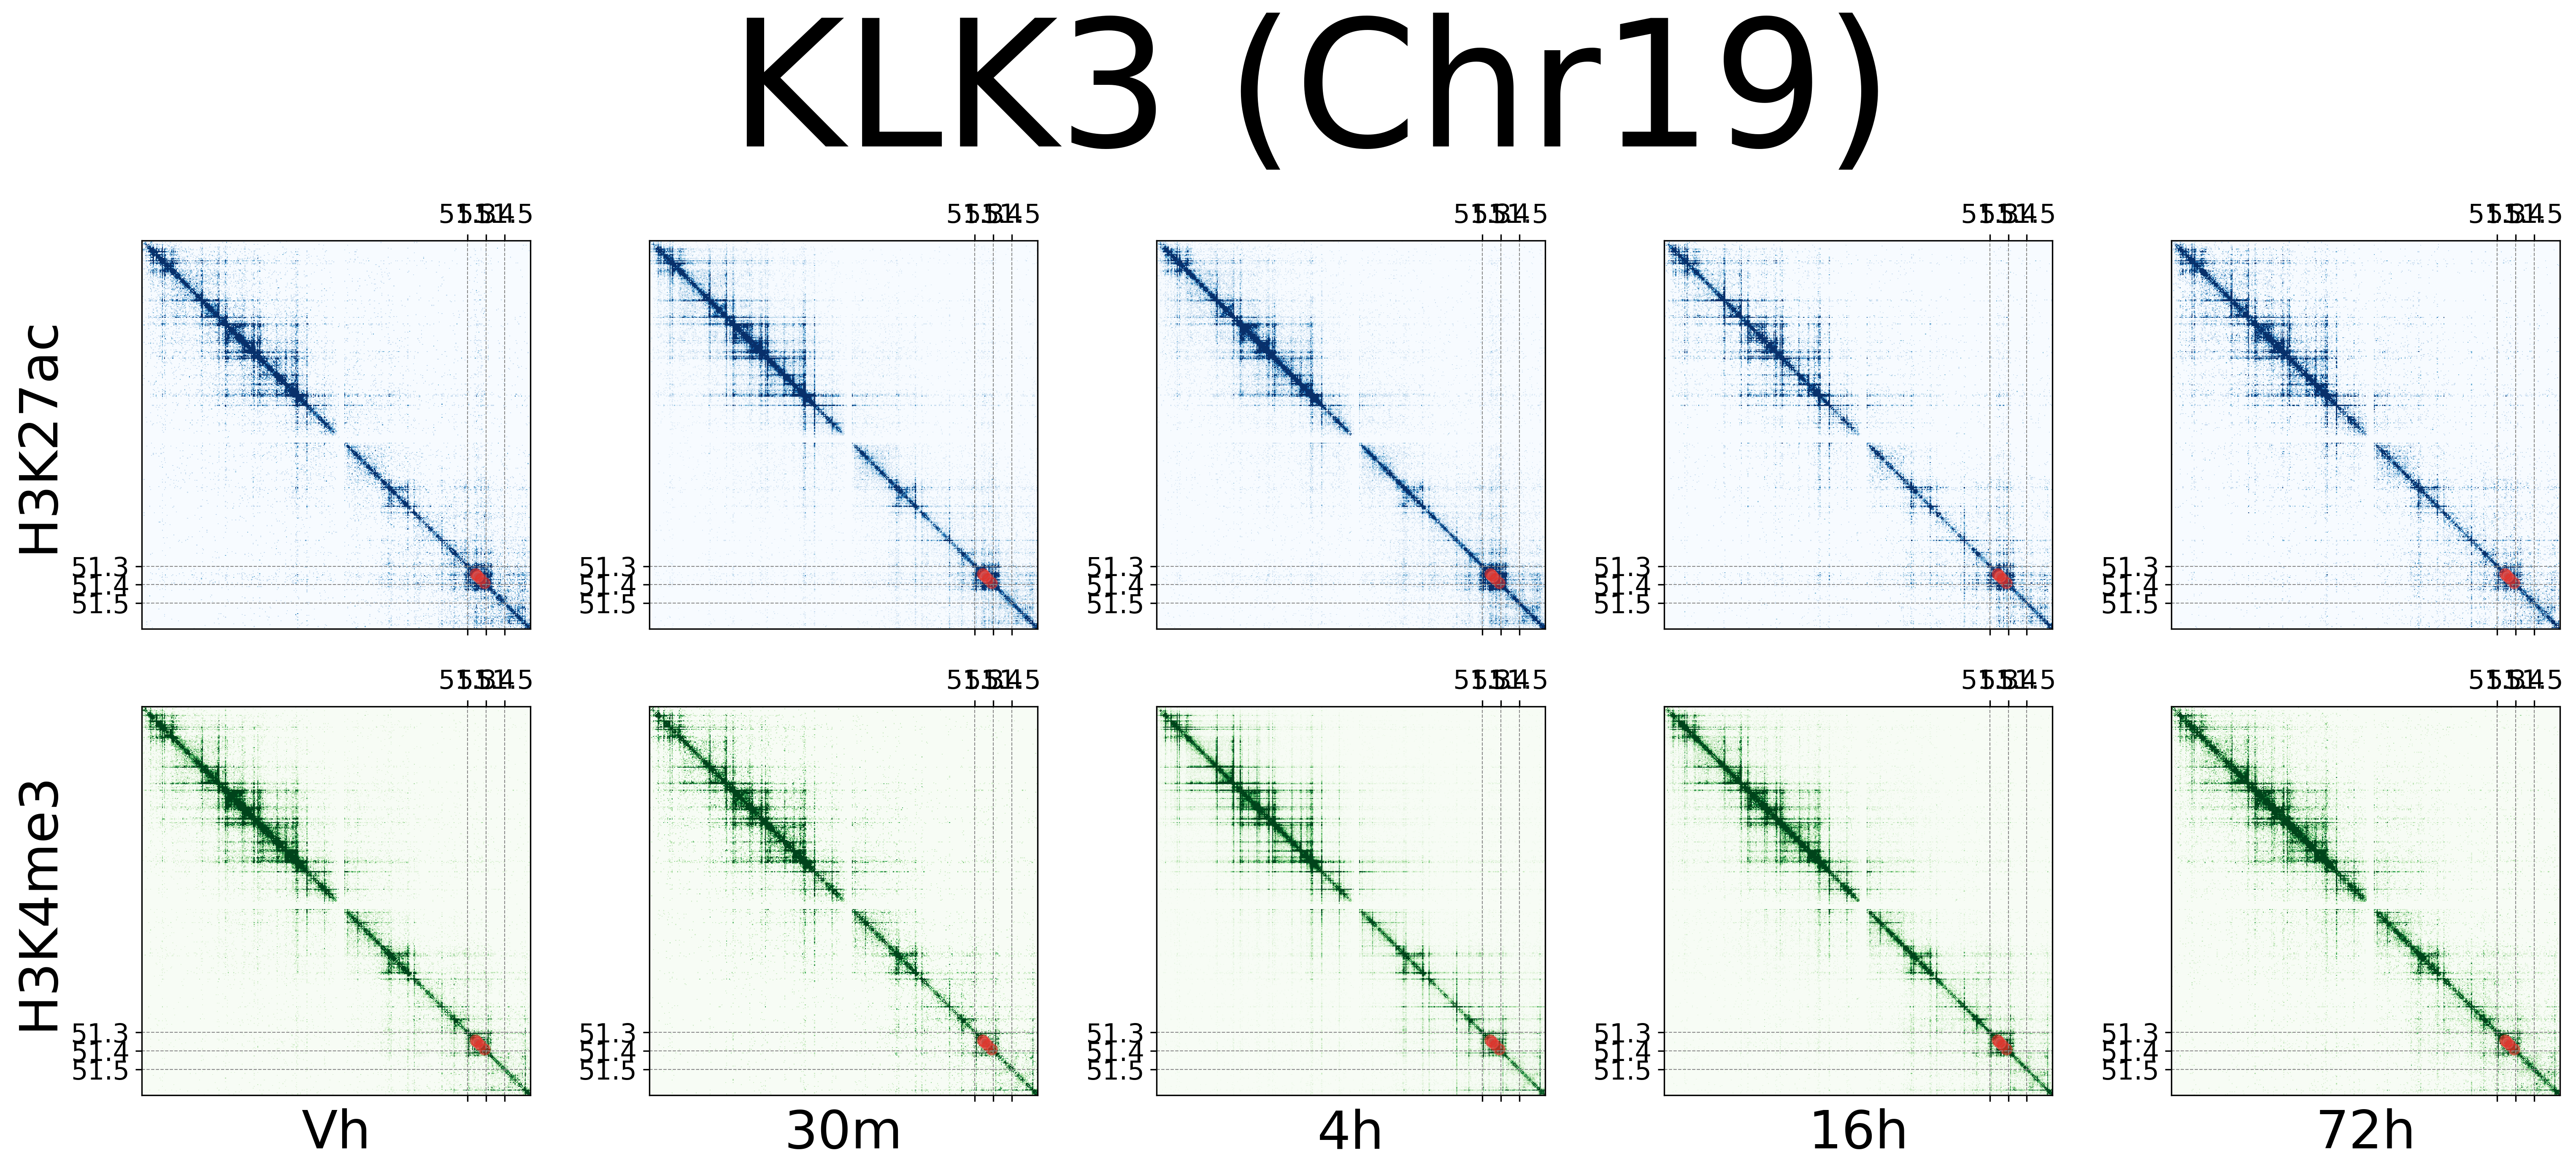

In [16]:

#chr19:49541590-51638742
region = ('chr19',49541590,51638742)
enhancers = (51342895, 51352016, 51370076, 51390631)
plotRegion(region, 'KLK3 (Chr19)',51355671, [51.3,51.4,51.5], enhancers, 0.00005)

In [9]:
H3K27ac_C

{'Vh': <Cooler "H3K27ac_Vh.cool::/">}

In [12]:
('chr19',51295000-(50*1000),51295000+(250*1000))

51245000- 51545000

-300000

0.011271261698203429
0.011614314265243788
0.012284293653114946
0.021315727422777646
0.015176543464794549
0.007304044478360406
0.012112403100775194
0.013511766227049393
0.013483364050829373
0.006345733041575492


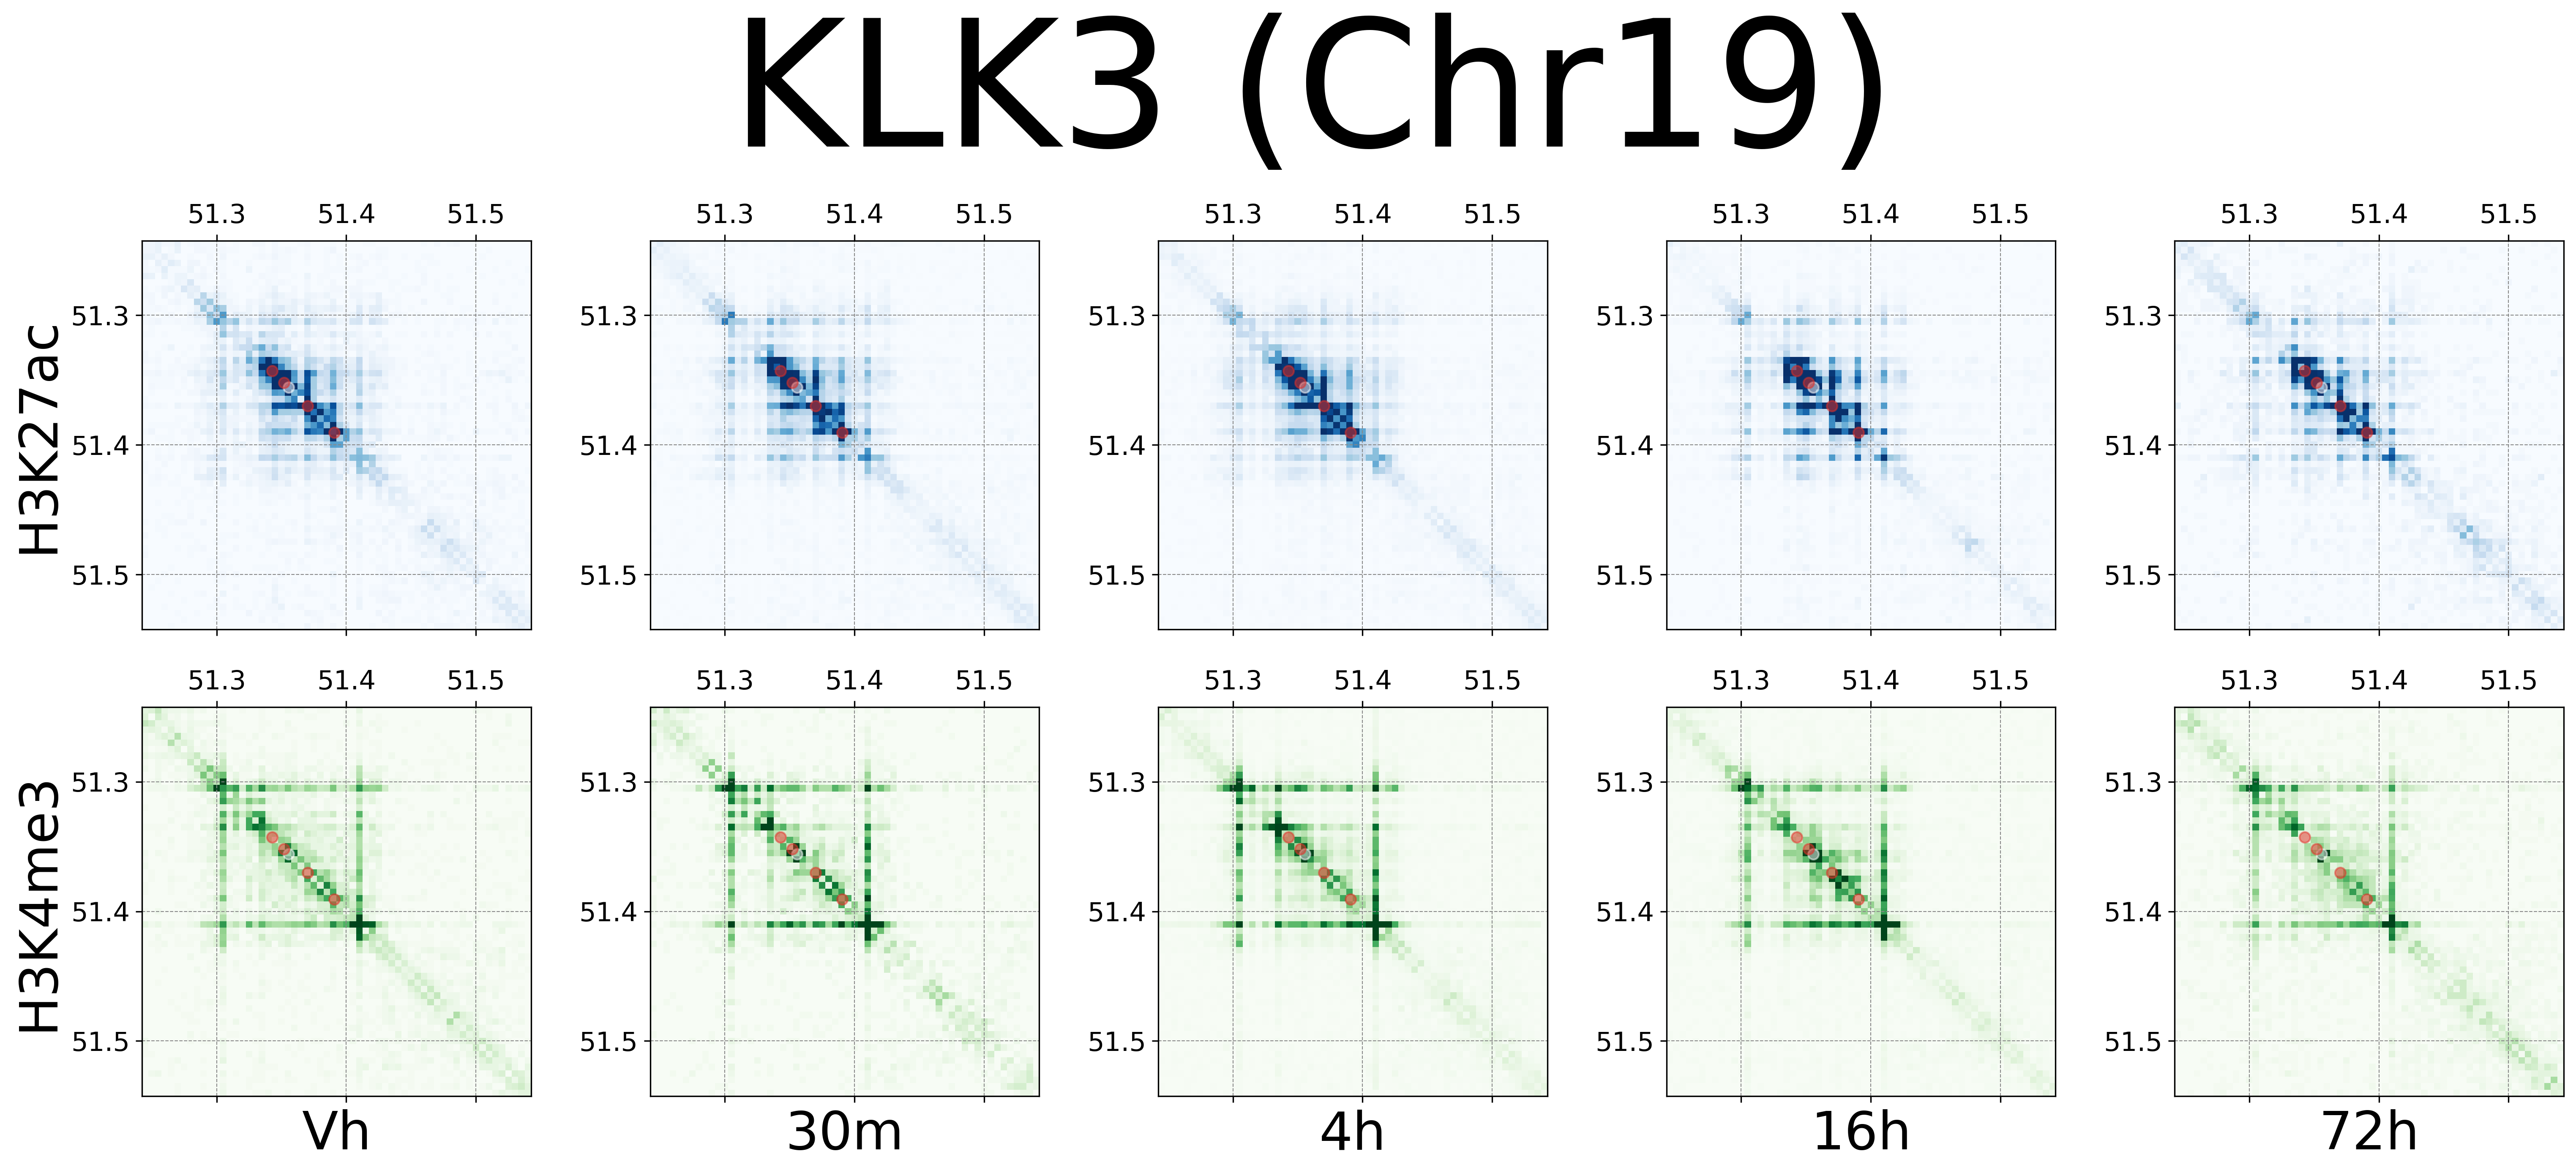

In [35]:


region = ('chr19',51295000-(50*1000),51295000+(250*1000))
enhancers = (51342895, 51352016, 51370076, 51390631)
plotRegion(region, 'KLK3 (Chr19)',51355671, [51.3,51.4,51.5], enhancers, 0.005)

0.014941666098110118
0.019713619713619714
0.012869704236610711
0.032017520988684364
0.03161795469487777
0.008854189383696079
0.011472415052977712
0.014115216892357127
0.009818973827971578
0.007812067150534656


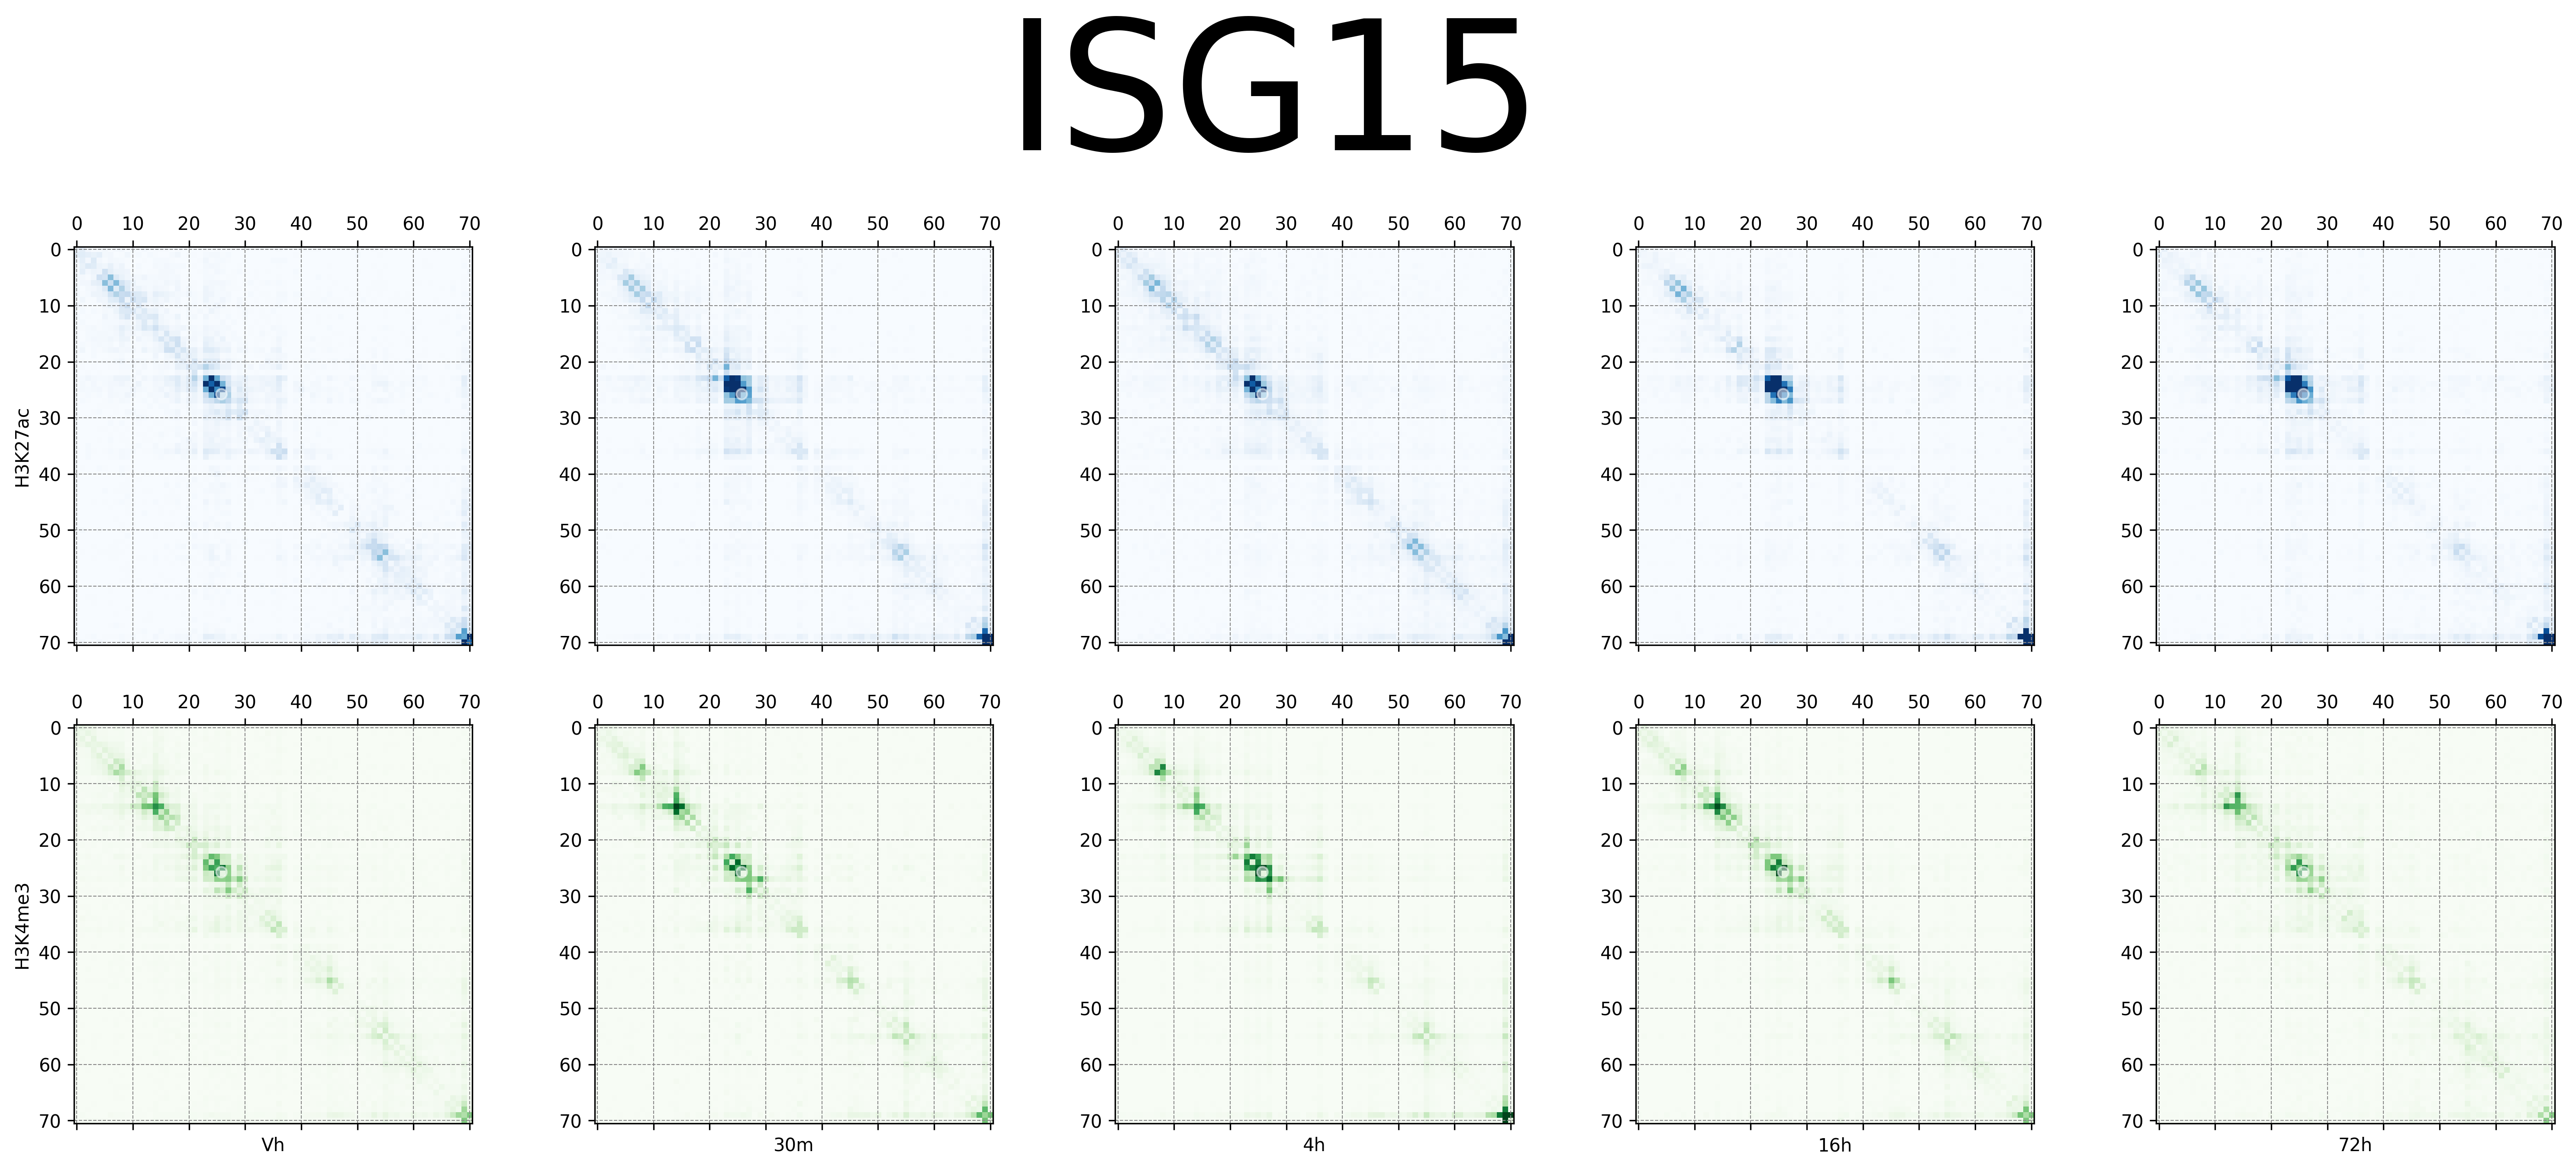

In [23]:
region = ('chr1',820216,1171260)



#region = ('chr19',51295000-(50*1000),51295000+(250*1000))
enhancers = (51342895, 51352016, 51370076, 51390631)
plotRegion(region, 'ISG15', promoter=948803, vmax=0.01)

0.01605929586164299
0.020813320525136087
0.02046438410074774
0.046102661596958174
0.032955159373311727
0.028733130169786677
0.034782608695652174
0.032885359397271434
0.022954545454545453
0.0231990231990232


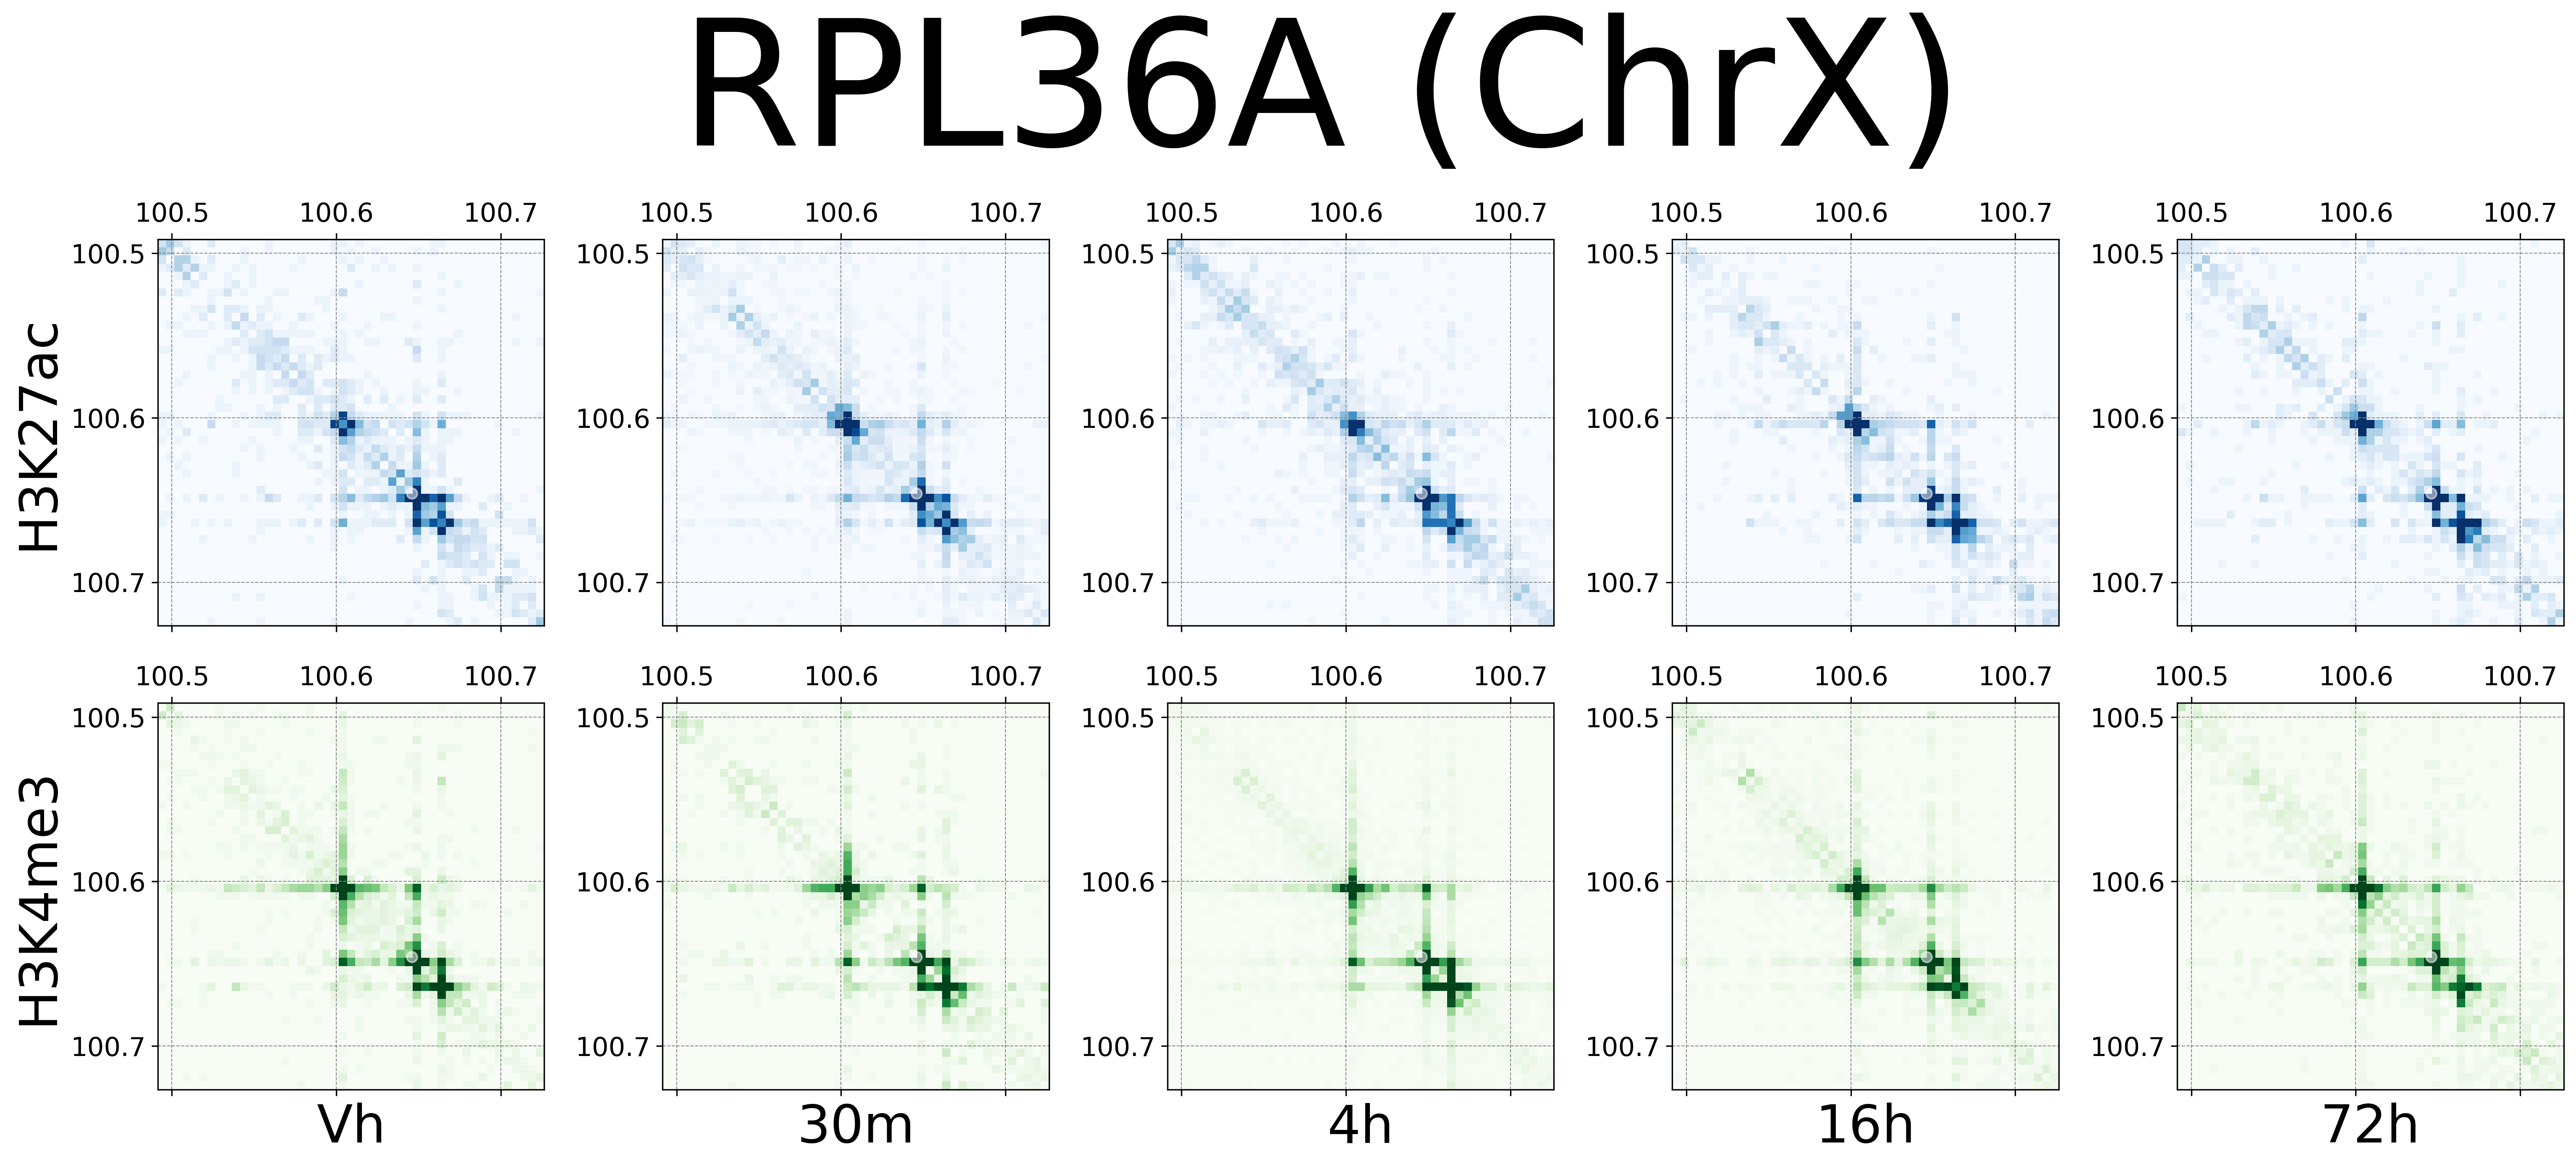

In [37]:
region = ('chrX',100493955,100722622)
p = (100643448+100648448) /2
ticks = [100.5, 100.6, 100.7]
#region = ('chr19',51295000-(50*1000),51295000+(250*1000))
enhancers = (51342895, 51352016, 51370076, 51390631)
plotRegion(region, 'RPL36A (ChrX)', promoter=p, ticks=ticks, vmax=0.01)

In [ ]:


region=('chrX',100503062,100731731)

p = (100643448+100648448) /2

#region = ('chr19',51295000-(50*1000),51295000+(250*1000))
enhancers = (51342895, 51352016, 51370076, 51390631)
plotRegion(region, 'HNRNPH2', promoter=p, vmax=0.01)

In [197]:
51295000-(50*1000),51295000+(250*1000)

(51245000, 51545000)

In [147]:
51.3*10**6 - region[1]

[], [51.3,51.4,51.5]

[51.3, 51.4, 51.5]

[11.0, 31.0, 51.0]

165
308
462
452
147
67
75
418
278
58


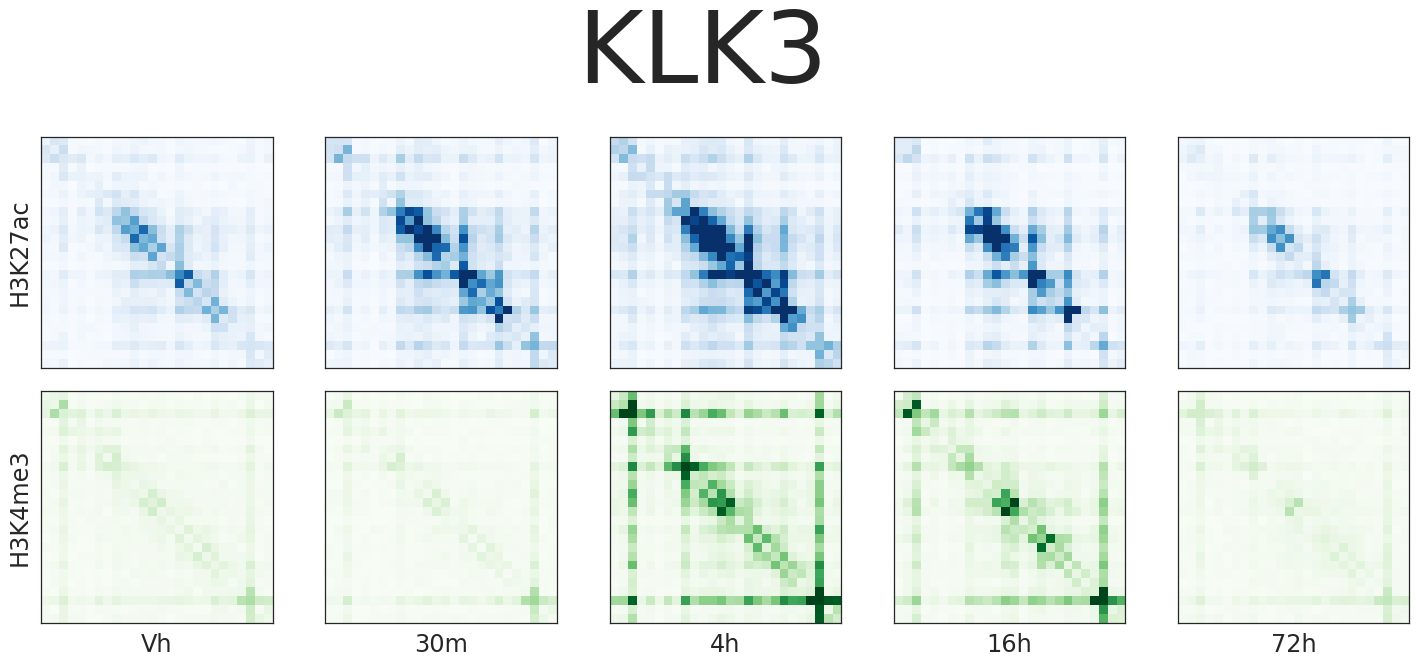

In [93]:


region = ('chr19',51298285,51423918)
plotRegion(region, 'KLK3', 200)

135
314
184
527
319
130
170
976
400
163


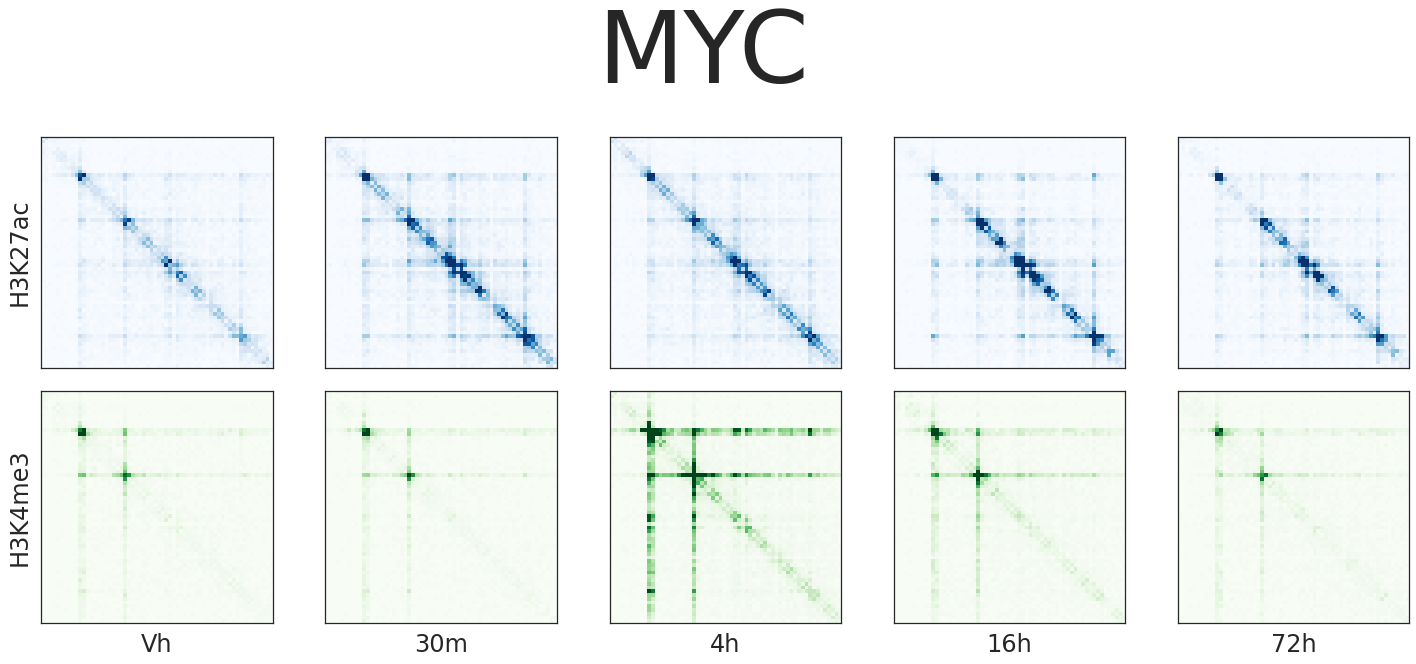

In [97]:
region = ('chr8', 128599155+10**5,128903719+10**5)

plotRegion(region, f'MYC', 100)

275
615
445
673
462
439
370
2061
664
272


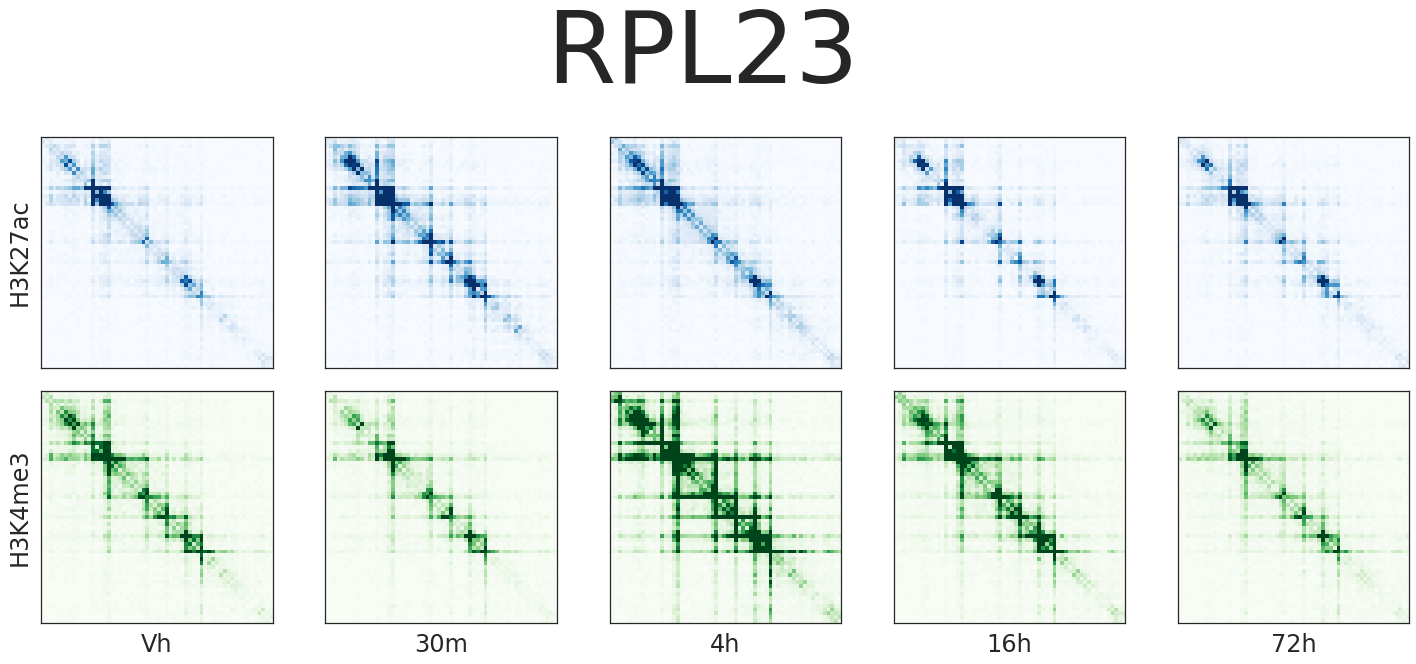

In [99]:

region = ('chr17',36824628,37118630)
plotRegion(region, 'RPL23', 100)

0.02512617950405969
0.030945268023223043
0.027700265432518887
0.06845582163501239
0.04696969696969697
140
153
715
236
109


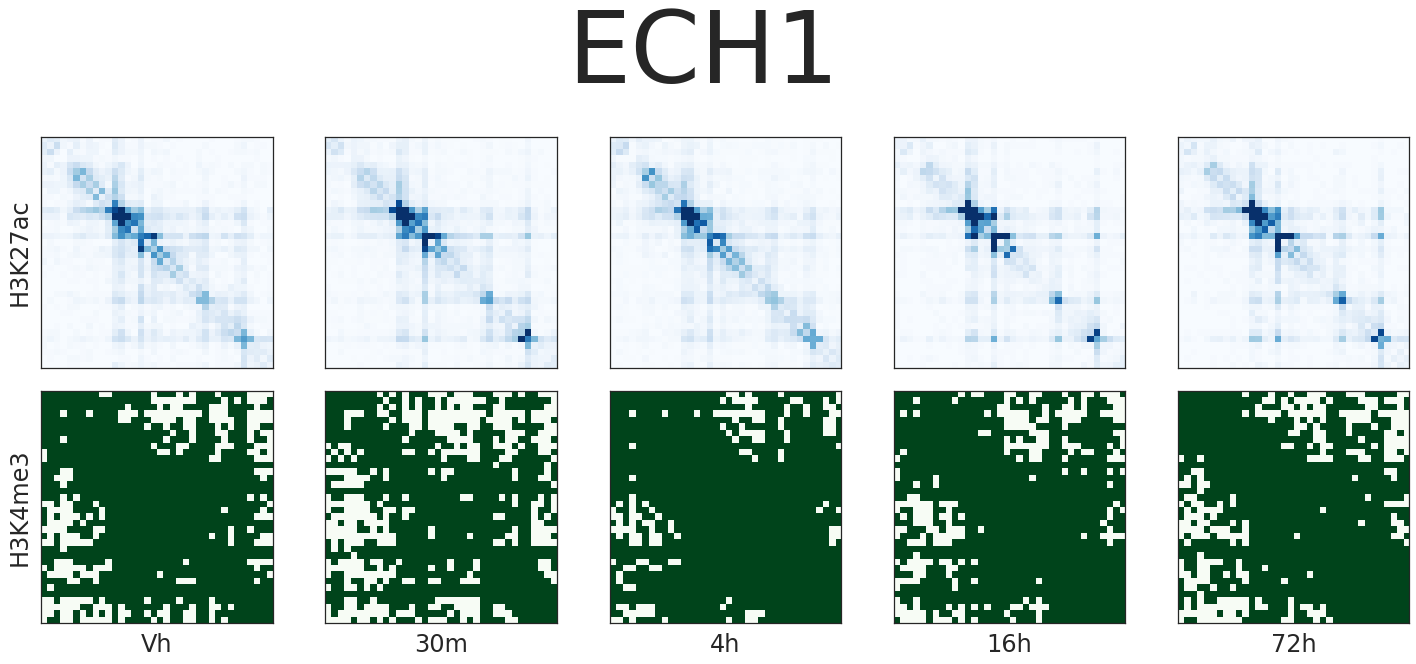

In [121]:
region = ('chr19',39268882,39444787)

plotRegion(region, 'ECH1', 0.01)

229
549
407
930
799
265
283
1201
563
197


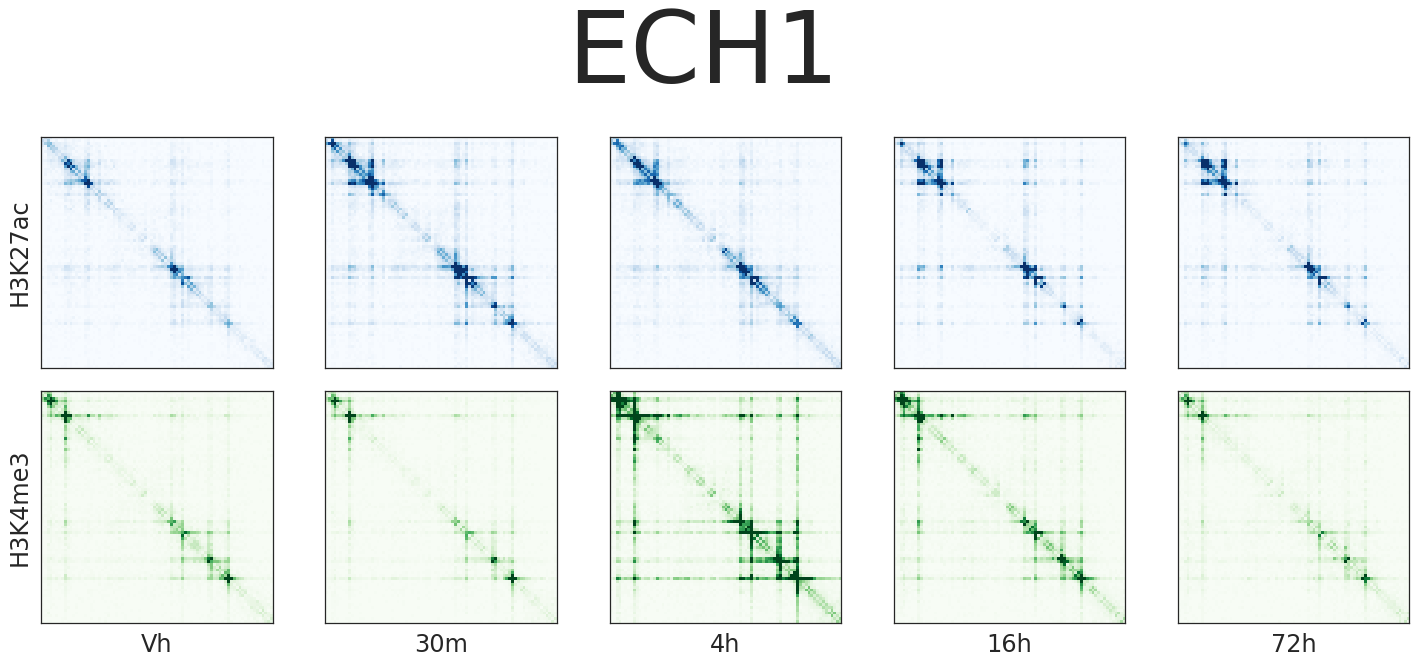

In [100]:
region = ('chr19',39099790,39499700)

plotRegion(region, 'ECH1', 100)

84
227
128
232
217
186
193
904
367
153


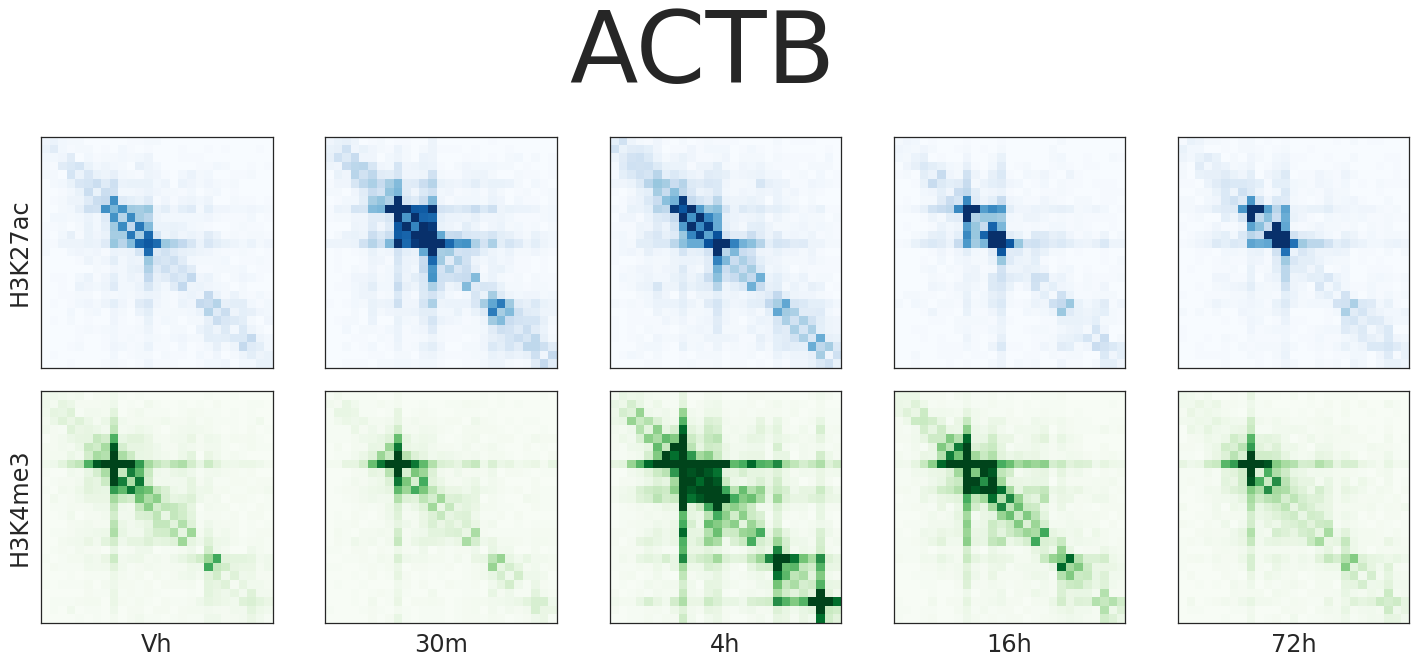

In [101]:
region = ('chr7',5511854,5641763)

plotRegion(region, 'ACTB', 100)

In [105]:
!bedtools merge -i ../data/BED/ARcre.bed -d 1000000


chr1	2339613	3450290
chr1	4654708	6220406
chr1	7256728	12558984
chr1	14822630	15067173
chr1	18514571	18519571
chr1	19751362	20361473
chr1	21653739	21661201
chr1	23408495	25361440
chr1	26404285	27695348
chr1	30153326	32970234
chr1	34123407	34128407
chr1	35789768	38663163
chr1	40007682	40345629
chr1	41679437	41684437
chr1	43502770	44261169
chr1	46858909	50591795
chr1	52023299	53640425
chr1	55345858	55943262
chr1	57251337	62110637
chr1	63206134	66920190
chr1	68036181	69978297
chr1	71766988	71771988
chr1	76532349	79759235
chr1	80855801	82240907
chr1	84226887	86003162
chr1	87256204	87486543
chr1	89443171	89448171
chr1	92022782	101713670
chr1	105171136	105941546
chr1	107184740	114980193
chr1	116493100	116752504
chr1	118102977	121291696
chr1	146820540	147101379
chr1	149580977	150181014
chr1	152116325	152166903
chr1	154111957	154394531
chr1	156583833	157708634
chr1	159636227	160104475
chr1	161792076	163589584
chr1	164635172	165041545
chr1	167092499	170069426
chr1	171310920	171544219
chr1	17271

60
145
117
189
116
205
204
951
310
147


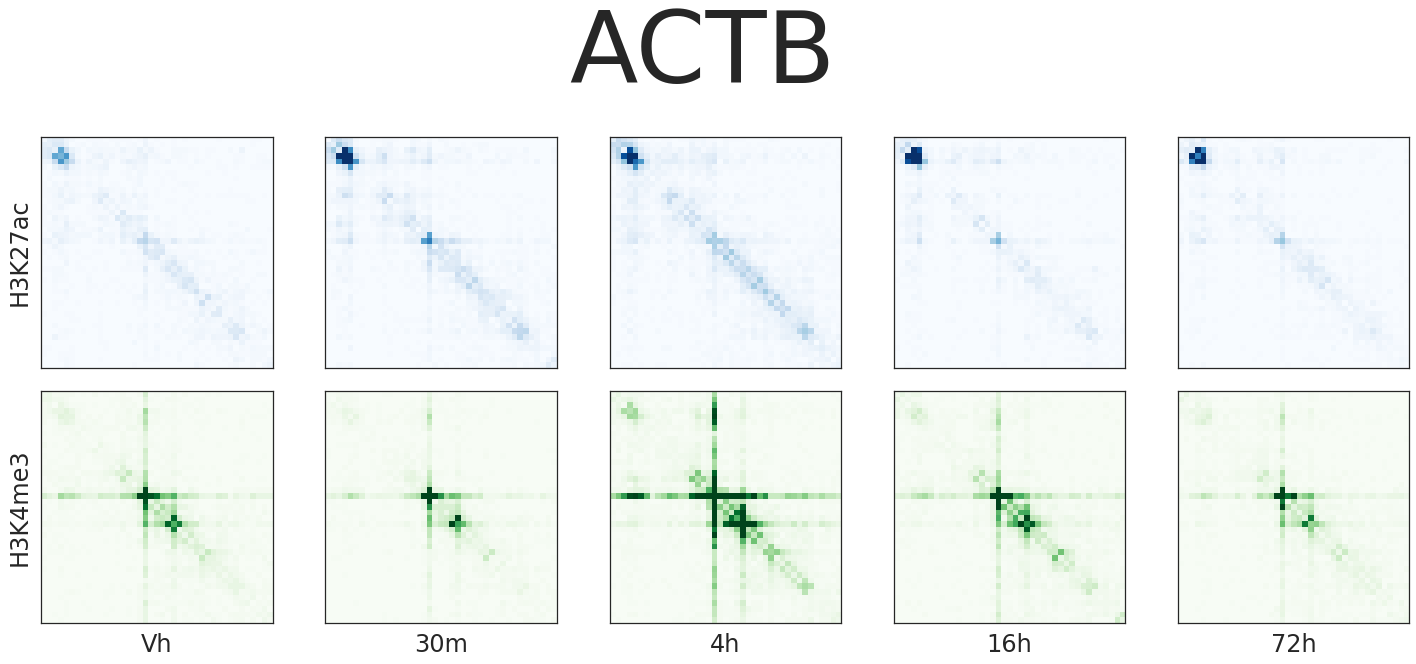

In [107]:

region = ('chr1', 3450290, 3654708)

plotRegion(region, 'ACTB', 100)